### Evaluating performance and drift of mortality decompensation model (LSTM) using a rolling window

In [1]:
import os
import random
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from cyclops.utils.file import load_pickle, save_pickle
from scipy.stats import pearsonr,spearmanr,mannwhitneyu

## Retraining

### Window Size

2023-02-21 15:31:38,000 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-02-21 15:31:38,248 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow7_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl
2023-02-21 15:31:38,433 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow14_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl
2023-02-21 15:31:38,568 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow30_statwindow14_update25000_epoch1_sample1000_threshold0

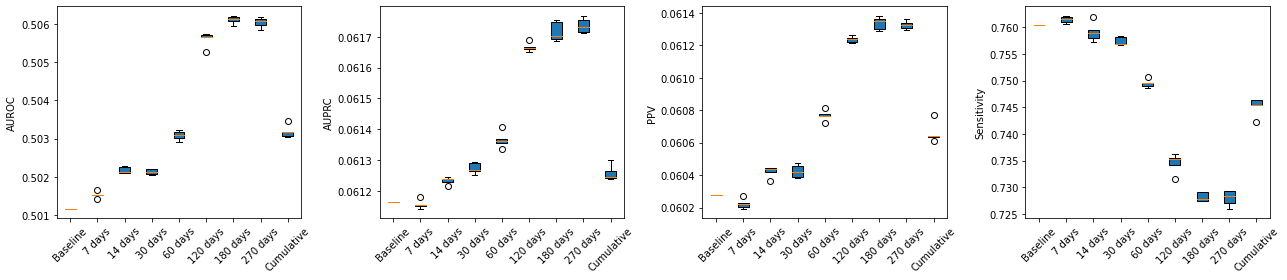

In [2]:
DATASET = "gemini"
USE_CASE = "mortality"
PATH = "/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/"
ID = "simulated_deployment"
TYPE = "update"
DR_TECHNIQUE = "BBSDs_trained_LSTM"
TESTER_METHOD = "ks"
N_RUNS = 5
UPDATE_REF=25000

THRESHOLD = 0.01
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1

window_size_labels = [
    "Baseline",
    "7 days",
    "14 days",
    "30 days",
    "60 days",
    "120 days",
    "180 days",
    "270 days",
    "Cumulative",
]

window_size_exp = {
    'Retraining Strategy' :  np.repeat(window_size_labels, N_RUNS),
    'Sensitivity' : [],
    'Specificity' : [],
    'PPV' : [],
    'AUROC' : [],
    'AUPRC' : [],
} 

for RETRAIN_WINDOW in ["baseline", 7, 14, 30, 60, 120, 180, 270,"cumulative"]:
    if RETRAIN_WINDOW == "cumulative":
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["cumulative",ID, "statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    elif RETRAIN_WINDOW == "baseline":
        path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+"_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
    else:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    all_runs = load_pickle(path)
    window_size_exp['Sensitivity'] = window_size_exp['Sensitivity'] + [np.mean(item['rec0']) for item in all_runs] 
    window_size_exp['Specificity'] = window_size_exp['Specificity'] + [np.mean(item['rec1']) for item in all_runs]
    window_size_exp['PPV'] = window_size_exp['PPV'] + [np.mean(item['prec1']) for item in all_runs]
    window_size_exp['AUROC'] = window_size_exp['AUROC'] + [np.mean(item['auroc']) for item in all_runs]
    window_size_exp['AUPRC'] = window_size_exp['AUPRC'] + [np.mean(item['auprc']) for item in all_runs]
    
window_size_exp = pd.DataFrame(window_size_exp)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for j, variable in enumerate(["AUROC","AUPRC","PPV", "Sensitivity"]):
    for i, grp in enumerate(window_size_exp.groupby("Retraining Strategy", sort=False)):
        axs[j].boxplot(
            x=variable, data=grp[1], positions=[i], widths=0.4, patch_artist=True
        )
        axs[j].set_xticks(range(0, len(window_size_labels)), window_size_labels, rotation=45, fontsize=10)
        axs[j].set_ylabel(variable, fontsize=10)
fig.tight_layout() 
plt.show()

2023-01-31 17:55:46,849 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-01-31 17:55:46,866 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl
2023-01-31 17:55:46,879 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update_correctonly.pkl
2023-01-31 17:55:46,891 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sampl

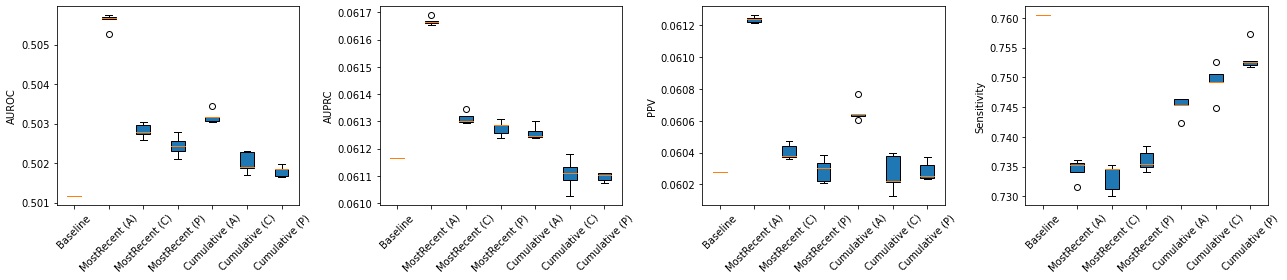

In [13]:
DATASET = "gemini"
USE_CASE = "mortality"
PATH = "/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/"
ID = "simulated_deployment"
TYPE = "update"
DR_TECHNIQUE = "BBSDs_trained_LSTM"
TESTER_METHOD = "ks"
N_RUNS = 5
UPDATE_REF=25000

THRESHOLD = 0.01
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1

window_size_labels = [
    "Baseline",
    "MostRecent (A)",
    "MostRecent (C)",
    "MostRecent (P)",
    "Cumulative (A)",
    "Cumulative (C)",
    "Cumulative (P)",
]

window_size_exp = {
    'Retraining Strategy' :  np.repeat(window_size_labels, N_RUNS),
    'Sensitivity' : [],
    'Specificity' : [],
    'PPV' : [],
    'AUROC' : [],
    'AUPRC' : [],
} 

for RETRAIN_WINDOW in ["baseline", 120, "mostrecent_c","mostrecent_p","cumulative","cumulative_c","cumulative_p"]:
    if RETRAIN_WINDOW == "cumulative":
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["cumulative",ID, "statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    elif RETRAIN_WINDOW == "baseline":
        path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+"_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
    elif RETRAIN_WINDOW == "mostrecent_c":
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(120),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE,"correctonly"])+".pkl")        
    elif RETRAIN_WINDOW == "mostrecent_p":
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(120),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE,"positiveonly"])+".pkl")        
    elif RETRAIN_WINDOW == "cumulative_c":
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["cumulative",ID, "statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE,"correctonly"])+".pkl")                
    elif RETRAIN_WINDOW == "cumulative_p":
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["cumulative",ID, "statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE,"positiveonly"])+".pkl")                
    else:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    all_runs = load_pickle(path)
    window_size_exp['Sensitivity'] = window_size_exp['Sensitivity'] + [np.mean(item['rec0']) for item in all_runs] 
    window_size_exp['Specificity'] = window_size_exp['Specificity'] + [np.mean(item['rec1']) for item in all_runs]
    window_size_exp['PPV'] = window_size_exp['PPV'] + [np.mean(item['prec1']) for item in all_runs]
    window_size_exp['AUROC'] = window_size_exp['AUROC'] + [np.mean(item['auroc']) for item in all_runs]
    window_size_exp['AUPRC'] = window_size_exp['AUPRC'] + [np.mean(item['auprc']) for item in all_runs]
    
window_size_exp = pd.DataFrame(window_size_exp)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for j, variable in enumerate(["AUROC","AUPRC","PPV", "Sensitivity"]):
    for i, grp in enumerate(window_size_exp.groupby("Retraining Strategy", sort=False)):
        axs[j].boxplot(
            x=variable, data=grp[1], positions=[i], widths=0.4, patch_artist=True
        )
        axs[j].set_xticks(range(0, len(window_size_labels)), window_size_labels, rotation=45, fontsize=10)
        axs[j].set_ylabel(variable, fontsize=10)
fig.tight_layout() 
plt.show()

## Periodic

2023-02-21 17:57:20,326 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-02-21 17:57:20,344 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl
2023-02-21 17:57:20,356 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/periodic_simulated_deployment_retrainwindow120_statwindow14_lookupwindow0_update25000_epoch1_sample1000_freq7_retraining_update.pkl
2023-02-21 17:57:20,367 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/periodic_simulated_deployment_retrainwindow120_statwindow14_lookupwindow0_update25000_epoch1_s

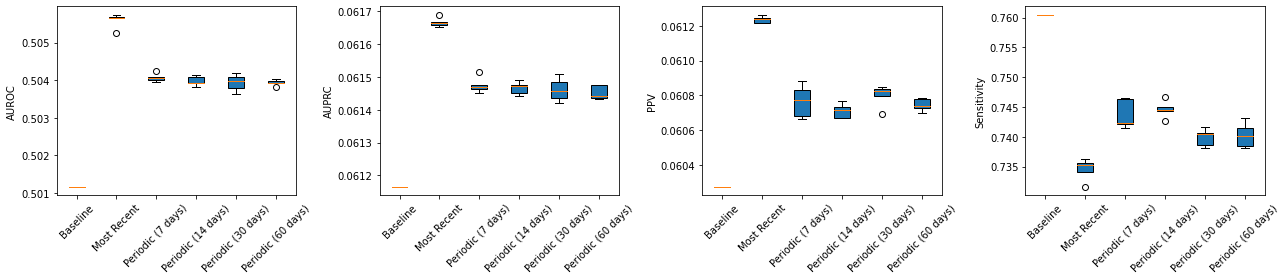

In [15]:
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1
RETRAIN_WINDOW=120
LOOKUP_WINDOW=0

freq_labels = [
    "Baseline",
    "Most Recent",
    "Periodic (7 days)",
    "Periodic (14 days)",
    "Periodic (30 days)",
    "Periodic (60 days)",
]

freq_exp = {
    'Retraining Strategy' :  np.repeat(freq_labels, N_RUNS),
    'Sensitivity' : [],
    'Specificity' : [],
    'PPV' : [],
    'AUROC' : [],
    'AUPRC' : [],
} 

for FREQ in ["baseline","mostrecent",7,14,30,60]:
    if FREQ == "baseline":
        path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+ "_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
    elif FREQ == "mostrecent":
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")        
    else:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["periodic",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"lookupwindow"+str(LOOKUP_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"freq"+str(FREQ),"retraining",TYPE])+".pkl")
    all_runs = load_pickle(path)
    freq_exp['Sensitivity'] = freq_exp['Sensitivity'] + [np.mean(item['rec0']) for item in all_runs] 
    freq_exp['Specificity'] = freq_exp['Specificity'] + [np.mean(item['rec1']) for item in all_runs]
    freq_exp['PPV'] = freq_exp['PPV'] + [np.mean(item['prec1']) for item in all_runs]
    freq_exp['AUROC'] = freq_exp['AUROC'] + [np.mean(item['auroc']) for item in all_runs]
    freq_exp['AUPRC'] = freq_exp['AUPRC'] + [np.mean(item['auprc']) for item in all_runs]
    
freq_exp = pd.DataFrame(freq_exp)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for j, variable in enumerate(["AUROC","AUPRC","PPV", "Sensitivity"]):
    for i, grp in enumerate(freq_exp.groupby("Retraining Strategy", sort=False)):
        axs[j].boxplot(
            x=variable, data=grp[1], positions=[i], widths=0.4, patch_artist=True
        )
        axs[j].set_xticks(range(0, len(freq_labels)), freq_labels, rotation=45, fontsize=10)
        axs[j].set_ylabel(variable, fontsize=10)
fig.tight_layout() 
plt.show()

### Sample Size

2023-01-29 16:37:40,900 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-01-29 16:37:40,917 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample50_threshold0.01_retraining_update.pkl
2023-01-29 16:37:40,929 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample100_threshold0.01_retraining_update.pkl
2023-01-29 16:37:40,941 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample250_threshold0

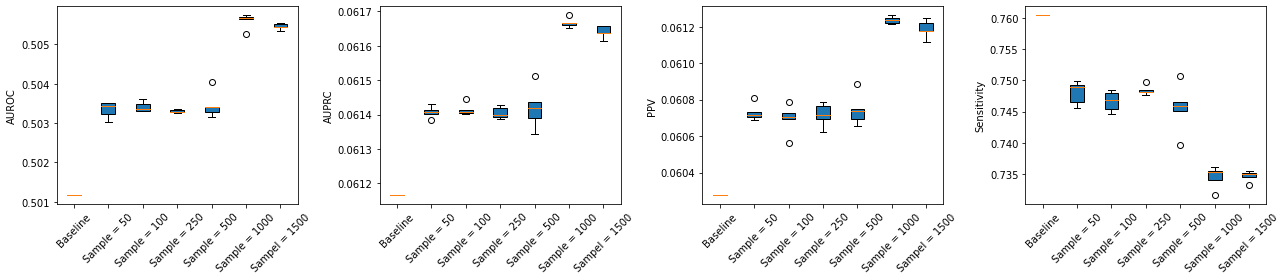

In [23]:
THRESHOLD = 0.01
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1
RETRAIN_WINDOW=120

sample_size_labels = [
    "Baseline",
    "Sample = 50",
    "Sample = 100",
    "Sample = 250",
    "Sample = 500",
    "Sample = 1000",
    "Sampel = 1500",
]

sample_size_exp = {
    'Retraining Strategy' :  np.repeat(sample_size_labels, N_RUNS),
    'Sensitivity' : [],
    'Specificity' : [],
    'PPV' : [],
    'AUROC' : [],
    'AUPRC' : [],
} 

for SAMPLE in ["baseline",50, 100,250,500,1000,1500]:
    if SAMPLE == "baseline":
        path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_1000"+ "_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
    else:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    all_runs = load_pickle(path)
    sample_size_exp['Sensitivity'] = sample_size_exp['Sensitivity'] + [np.mean(item['rec0']) for item in all_runs] 
    sample_size_exp['Specificity'] = sample_size_exp['Specificity'] + [np.mean(item['rec1']) for item in all_runs]
    sample_size_exp['PPV'] = sample_size_exp['PPV'] + [np.mean(item['prec1']) for item in all_runs]
    sample_size_exp['AUROC'] = sample_size_exp['AUROC'] + [np.mean(item['auroc']) for item in all_runs]
    sample_size_exp['AUPRC'] = sample_size_exp['AUPRC'] + [np.mean(item['auprc']) for item in all_runs]
    
sample_size_exp = pd.DataFrame(sample_size_exp)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for j, variable in enumerate(["AUROC","AUPRC","PPV", "Sensitivity"]):
    for i, grp in enumerate(sample_size_exp.groupby("Retraining Strategy", sort=False)):
        axs[j].boxplot(
            x=variable, data=grp[1], positions=[i], widths=0.4, patch_artist=True
        )
        axs[j].set_xticks(range(0, len(sample_size_labels)), sample_size_labels, rotation=45, fontsize=10)
        axs[j].set_ylabel(variable, fontsize=10)
fig.tight_layout() 
plt.show()

### Drift threshold

2023-01-29 02:42:44,994 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-01-29 02:42:45,009 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.1_retraining_update.pkl
2023-01-29 02:42:45,028 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.05_retraining_update.pkl
2023-01-29 02:42:45,042 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_thresho

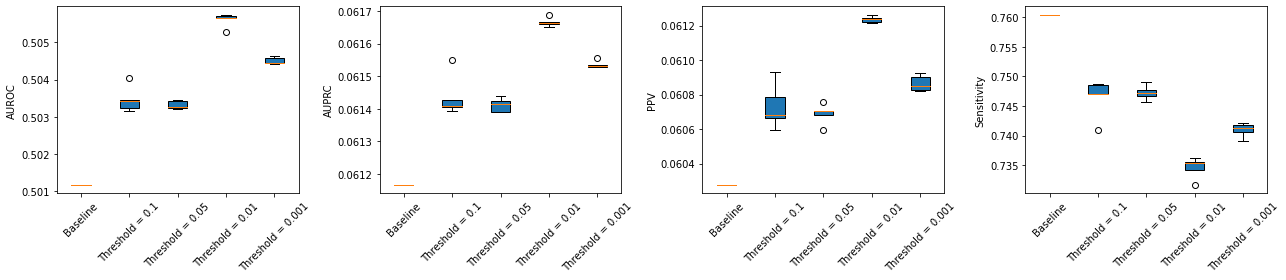

In [46]:
THRESHOLD = 0.01
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1
RETRAIN_WINDOW=120

threshold_labels = [
    "Baseline",
    "Threshold = 0.1",
    "Threshold = 0.05",
    "Threshold = 0.01",
    "Threshold = 0.001",
]

threshold_exp = {
    'Retraining Strategy' :  np.repeat(threshold_labels, N_RUNS),
    'Sensitivity' : [],
    'Specificity' : [],
    'PPV' : [],
    'AUROC' : [],
    'AUPRC' : [],
} 

for THRESHOLD in ["baseline",0.1,0.05,0.01,0.001]:
    if THRESHOLD == "baseline":
        path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+ "_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
    else:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    all_runs = load_pickle(path)
    threshold_exp['Sensitivity'] = threshold_exp['Sensitivity'] + [np.mean(item['rec0']) for item in all_runs] 
    threshold_exp['Specificity'] = threshold_exp['Specificity'] + [np.mean(item['rec1']) for item in all_runs]
    threshold_exp['PPV'] = threshold_exp['PPV'] + [np.mean(item['prec1']) for item in all_runs]
    threshold_exp['AUROC'] = threshold_exp['AUROC'] + [np.mean(item['auroc']) for item in all_runs]
    threshold_exp['AUPRC'] = threshold_exp['AUPRC'] + [np.mean(item['auprc']) for item in all_runs]
    
threshold_exp = pd.DataFrame(threshold_exp)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for j, variable in enumerate(["AUROC","AUPRC","PPV", "Sensitivity"]):
    for i, grp in enumerate(threshold_exp.groupby("Retraining Strategy", sort=False)):
        axs[j].boxplot(
            x=variable, data=grp[1], positions=[i], widths=0.4, patch_artist=True
        )
        axs[j].set_xticks(range(0, len(threshold_labels)), threshold_labels, rotation=45, fontsize=10)
        axs[j].set_ylabel(variable, fontsize=10)
fig.tight_layout() 
plt.show()

### Number of Epochs

2023-01-29 12:51:04,487 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-01-29 12:51:04,507 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl
2023-01-29 12:51:04,534 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch5_sample1000_threshold0.01_retraining_update.pkl
2023-01-29 12:51:04,547 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch10_sample1000_thres

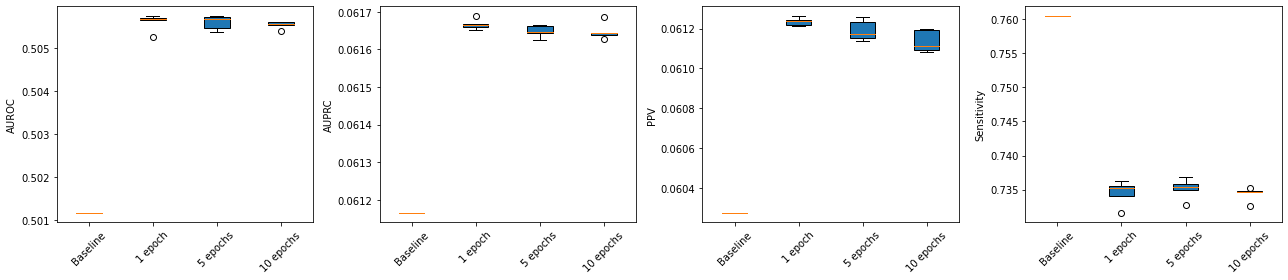

In [10]:
THRESHOLD = 0.01
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1
RETRAIN_WINDOW=120

epoch_labels = [
    "Baseline",
    "1 epoch",
    "5 epochs",
    "10 epochs",
#    "Retrain",
]

epoch_exp = {
    'Retraining Strategy' :  np.repeat(epoch_labels, N_RUNS),
    'Sensitivity' : [],
    'Specificity' : [],
    'PPV' : [],
    'AUROC' : [],
    'AUPRC' : [],
} 

for N_EPOCHS in ["baseline",1,5,10]:
    if N_EPOCHS == "baseline":
        path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+ "_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
    else:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    all_runs = load_pickle(path)
    epoch_exp['Sensitivity'] = epoch_exp['Sensitivity'] + [np.mean(item['rec0']) for item in all_runs] 
    epoch_exp['Specificity'] = epoch_exp['Specificity'] + [np.mean(item['rec1']) for item in all_runs]
    epoch_exp['PPV'] = epoch_exp['PPV'] + [np.mean(item['prec1']) for item in all_runs]
    epoch_exp['AUROC'] = epoch_exp['AUROC'] + [np.mean(item['auroc']) for item in all_runs]
    epoch_exp['AUPRC'] = epoch_exp['AUPRC'] + [np.mean(item['auprc']) for item in all_runs]
    
epoch_exp = pd.DataFrame(epoch_exp)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for j, variable in enumerate(["AUROC","AUPRC","PPV", "Sensitivity"]):
    for i, grp in enumerate(epoch_exp.groupby("Retraining Strategy", sort=False)):
        axs[j].boxplot(
            x=variable, data=grp[1], positions=[i], widths=0.4, patch_artist=True
        )
        axs[j].set_xticks(range(0, len(epoch_labels)), epoch_labels, rotation=45, fontsize=10)
        axs[j].set_ylabel(variable, fontsize=10)
fig.tight_layout() 
plt.show()

2023-01-30 11:15:54,493 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-01-30 11:15:54,509 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl
2023-01-30 11:15:54,521 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_lookupwindow30_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl
2023-01-30 11:15:54,531 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_lookupwindow60_update

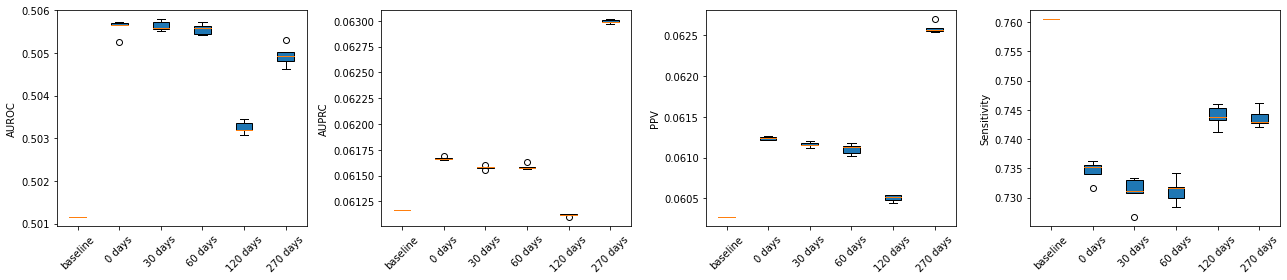

In [5]:
THRESHOLD = 0.01
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1
RETRAIN_WINDOW=120

lookup_labels = [
    "baseline",
    "0 days",
    "30 days",
    "60 days",
    "120 days",
    "270 days",
]

lookup_exp = {
    'Retraining Strategy' :  np.repeat(lookup_labels, N_RUNS),
    'Sensitivity' : [],
    'Specificity' : [],
    'PPV' : [],
    'AUROC' : [],
    'AUPRC' : [],
} 

for LOOKUP_WINDOW in ["baseline",0,30,60,120,270]:
    if LOOKUP_WINDOW == "baseline":
        path = os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+ "_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl")
    elif LOOKUP_WINDOW == 0:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    else:
        path = os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"lookupwindow"+str(LOOKUP_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl")
    all_runs = load_pickle(path)
    lookup_exp['Sensitivity'] = lookup_exp['Sensitivity'] + [np.mean(item['rec0']) for item in all_runs] 
    lookup_exp['Specificity'] = lookup_exp['Specificity'] + [np.mean(item['rec1']) for item in all_runs]
    lookup_exp['PPV'] = lookup_exp['PPV'] + [np.mean(item['prec1']) for item in all_runs]
    lookup_exp['AUROC'] = lookup_exp['AUROC'] + [np.mean(item['auroc']) for item in all_runs]
    lookup_exp['AUPRC'] = lookup_exp['AUPRC'] + [np.mean(item['auprc']) for item in all_runs]
    
lookup_exp = pd.DataFrame(lookup_exp)

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for j, variable in enumerate(["AUROC","AUPRC","PPV", "Sensitivity"]):
    for i, grp in enumerate(lookup_exp.groupby("Retraining Strategy", sort=False)):
        axs[j].boxplot(
            x=variable, data=grp[1], positions=[i], widths=0.4, patch_artist=True
        )
        axs[j].set_xticks(range(0, len(lookup_labels)), lookup_labels, rotation=45, fontsize=10)
        axs[j].set_ylabel(variable, fontsize=10)
fig.tight_layout() 
plt.show()

In [ ]:
THRESHOLD = 0.01
SAMPLE = 1000
STAT_WINDOW = 14
N_EPOCHS = 1
RETRAIN_WINDOW=120

baseline = load_pickle(os.path.join(PATH, DATASET,USE_CASE, "drift", ID + "_"+str(STAT_WINDOW)+"_"+str(SAMPLE)+"_"+str(UPDATE_REF)+"_"+DR_TECHNIQUE+"_"+TESTER_METHOD+"_rolling_window.pkl"))
retrained = load_pickle(os.path.join(PATH, DATASET,USE_CASE, "_".join(["mostrecent",ID, "retrainwindow"+str(RETRAIN_WINDOW),"statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl"))
#retrained = load_pickle(os.path.join(PATH, DATASET,USE_CASE, "_".join(["cumulative",ID, "statwindow"+str(STAT_WINDOW),"update"+str(UPDATE_REF),"epoch"+str(N_EPOCHS),"sample"+str(SAMPLE),"threshold"+str(THRESHOLD),"retraining",TYPE])+".pkl"))
avg_baseline = {} ; avg_retrained = {}
for key, val in baseline[0].items():
    if key != "timestamps":
        avg_baseline[key] = [(a+b+c+d+e) / 5 for a,b,c,d,e in zip(baseline[0][key],baseline[1][key],baseline[2][key],baseline[3][key],baseline[4][key])]
        avg_baseline[key+"_error"] = [np.std([a,b,c,d,e]) for a,b,c,d,e in zip(baseline[0][key],baseline[1][key],baseline[2][key],baseline[3][key],baseline[4][key])]
    else: #/np.sqrt(np.size([a,b,c,d,e]))
        avg_baseline[key] = baseline[0][key]
for key, val in retrained[0].items():
    if key != "timestamps":
        avg_retrained[key] = [(a+b+c+d+e) / 5 for a,b,c,d,e in zip(retrained[0][key],retrained[1][key],retrained[2][key],retrained[3][key],retrained[4][key])]
        avg_retrained[key+"_error"] = [np.std([a,b,c,d,e]) for a,b,c,d,e in zip(retrained[0][key],retrained[1][key],retrained[2][key],retrained[3][key],retrained[4][key])]        
results = {}
for key, val in avg_baseline.items():
    if key in ['prec0','rec0','auroc','auprc','prec1','rec1','acc']:
        assert len(avg_baseline[key]) == len(avg_retrained[key])
        results[key] = [x1 - x2 for (x1, x2) in zip(avg_retrained[key], avg_baseline[key])]
    else:
        results[key] = avg_baseline[key]

2023-01-29 23:51:28,745 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/drift/simulated_deployment_14_1000_25000_BBSDs_trained_LSTM_ks_rolling_window.pkl
2023-01-29 23:51:28,777 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/mostrecent_simulated_deployment_retrainwindow120_statwindow14_update25000_epoch1_sample1000_threshold0.01_retraining_update.pkl


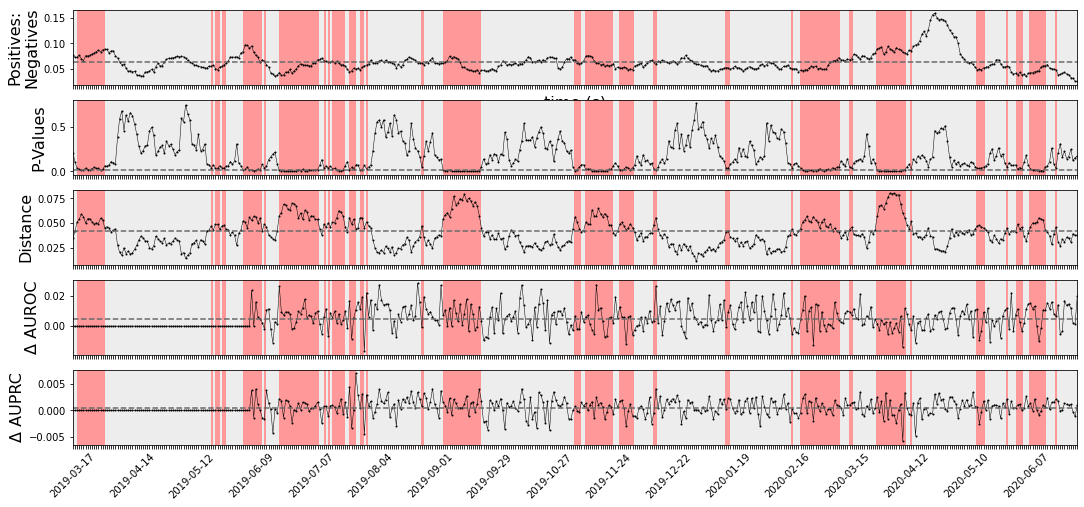

In [10]:
from matplotlib.colors import ListedColormap

START=60
sig_drift = np.array(results["shift_detected"][START:])[np.newaxis]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(18, 8))
cmap = ListedColormap(["lightgrey", "red"])


ax1.plot(
    results["timestamps"][START:],
    results["outcome_prop"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax1.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax1.set_ylabel("Positives:\nNegatives", fontsize=16)
ax1.set_xlabel("time (s)", fontsize=16)
ax1.set_xticklabels([])
ax1.axhline(y=np.nanmean(results["outcome_prop"]), color="dimgrey", linestyle="--")
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)


ax2.plot(
    results["timestamps"][START:],
    results["p_val"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax2.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax2.axhline(y=THRESHOLD, color="dimgrey", linestyle="--")
ax2.set_ylabel("P-Values", fontsize=16)
ax2.set_xticklabels([])
ax2.fill_between(results["timestamps"][START:], 
                 [x1 - x2*2 for (x1, x2) in zip(results["p_val"][START:], results["p_val_error"][START:])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["p_val"][START:], results["p_val_error"][START:])], facecolor ='black', alpha = 0.25)
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax3.plot(
    results["timestamps"][START:],
    results["distance"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax3.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax3.set_ylabel("Distance", fontsize=16)
ax3.axhline(y=np.nanmean(results["distance"]), color="dimgrey", linestyle="--")
ax3.set_xticklabels([])
ax3.fill_between(results["timestamps"][START:], 
                 [x1 - x2*2 for (x1, x2) in zip(results["distance"][START:], results["distance_error"][START:])], 
                 [x1 + x2*2 for (x1, x2) in zip(results["distance"][START:], results["distance_error"][START:])], facecolor ='black', alpha = 0.25)
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax4.plot(
    results["timestamps"][START:],
    results["auroc"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax4.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax4.set_ylabel("Δ AUROC", fontsize=16)
ax4.axhline(y=np.nanmean(results["auroc"]), color="dimgrey", linestyle="--")
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

ax5.plot(
    results["timestamps"][START:],
    results["auprc"][START:],
    ".-",
    color="black",
    linewidth=0.5,
    markersize=2,
)
ax5.set_xlim(results["timestamps"][START], results["timestamps"][-1])
ax5.set_ylabel("Δ AUPRC", fontsize=16)
ax5.axhline(y=np.nanmean(results["auprc"]), color="dimgrey", linestyle="--")
ax5.tick_params(axis="x", labelrotation=45)
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)

for index, label in enumerate(ax5.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Relationship between Performance and Drift P-Value

In [78]:
for fract in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    limit=(np.mean(avg_baseline['auroc']) - fract*np.std(avg_baseline['auroc']))
    limit_FP=(np.mean(avg_baseline['auroc']) - fract*np.std(avg_baseline['auroc']))
    indices = [i for i, x in enumerate(avg_baseline['auroc']) if x < limit]
    indices_FP = [i for i, x in enumerate(avg_baseline['auroc']) if x < limit_FP]
    detected = [avg_baseline['p_val'][i] for i in indices]
    detected_FP = [avg_baseline['p_val'][i] for i in indices_FP]
    TP = sum(i < 0.05 for i in detected)/len(detected)
    FP = sum(i > 0.05 for i in detected_FP)/len(detected)
    print(TP,FP)  

0.36134453781512604 0.6386554621848739
0.36283185840707965 0.6371681415929203
0.35121951219512193 0.6487804878048781
0.34408602150537637 0.6559139784946236
0.3374233128834356 0.6625766871165644
0.33783783783783783 0.6621621621621622
0.30708661417322836 0.6929133858267716
0.3148148148148148 0.6851851851851852
0.3157894736842105 0.6842105263157895
0.2988505747126437 0.7011494252873564


Pearsons correlation: 0.062 P-Value: 0.150
Spearmans correlation: 0.036 P-Value: 0.410
Mann Whitney U Test: 17193.000 P-Value: 0.000
Linear Regression: 0.062 P-Value: 0.150


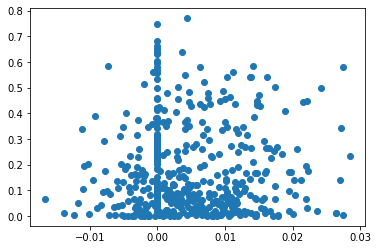

In [61]:
from scipy.stats import pearsonr,spearmanr,mannwhitneyu,linregress
def plot_correlation(results,metric="auroc"):
    pcorr, pcorr_pval = pearsonr(results[metric], results["p_val"])
    print("Pearsons correlation: %.3f P-Value: %.3f" % (pcorr, pcorr_pval))
    # calculate spearman's correlation
    scorr, scorr_pval = spearmanr(results[metric], results["p_val"])
    print("Spearmans correlation: %.3f P-Value: %.3f" % (scorr, scorr_pval))
    U1, p = mannwhitneyu(results[metric], results["p_val"])
    print("Mann Whitney U Test: %.3f P-Value: %.3f" % (U1, p))
    slope, intercept, r_value, p_value, std_err = linregress(results[metric], results["p_val"])
    print("Linear Regression: %.3f P-Value: %.3f" % (r_value, p_value))
    # plot
    plt.scatter(results[metric], results["p_val"])
    plt.show()
    
plot_correlation(results,"auroc")

Pearsons correlation: 0.031 P-Value: 0.472
Spearmans correlation: 0.008 P-Value: 0.861
Mann Whitney U Test: 4933.000 P-Value: 0.000
Linear Regression: 0.031 P-Value: 0.472


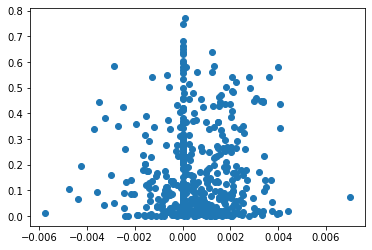

In [62]:
plot_correlation(results,"auprc")

Pearsons correlation: -0.075 P-Value: 0.085
Spearmans correlation: -0.121 P-Value: 0.005
Mann Whitney U Test: 64302.000 P-Value: 0.000
Linear Regression: -0.075 P-Value: 0.085


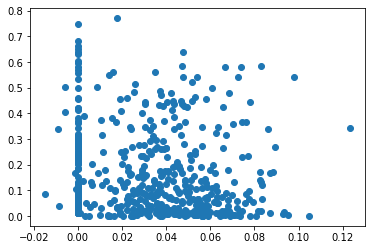

In [63]:
plot_correlation(results,"rec1")

Pearsons correlation: 0.074 P-Value: 0.088
Spearmans correlation: 0.106 P-Value: 0.014
Mann Whitney U Test: 0.000 P-Value: 0.000
Linear Regression: 0.074 P-Value: 0.088


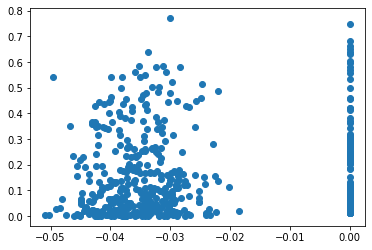

In [64]:
plot_correlation(results,"rec0")

Pearsons correlation: 0.009 P-Value: 0.833
Spearmans correlation: -0.050 P-Value: 0.248
Mann Whitney U Test: 7932.000 P-Value: 0.000
Linear Regression: 0.009 P-Value: 0.833


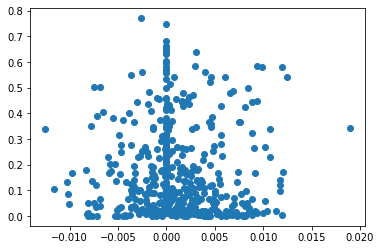

In [65]:
plot_correlation(results,"prec1")